In [2]:
#Basic shit
import re
import numpy as np
import random
import time
from datetime import datetime, timedelta
import math
from IPython.display import Image


#Dataframes + read data
import pickle
import json 
import geojson
import geocoder

import pandas as pd      #Package for handling large data structures
import geopandas as gpd  #http://localhost:8888/notebooks/KTH/GitHub/DF23_cycle/M_stat_all.ipynb#Package for handling geospatial data
from geopandas import GeoDataFrame, read_file
from pyproj import CRS   #coordinate reference system

#Shapes
from shapely.geometry import Point, LineString, Polygon, MultiPoint, MultiLineString, shape
from shapely import wkt  #If the geo_data is in wkt-format, this package is needed to "read" that (wtk - well known text)
import shapely as shp
from shapely.geometry import box

#Plotting
import hvplot.pandas 
import matplotlib.pyplot as plt
from holoviews import opts, dim
import warnings
warnings.filterwarnings('ignore')

plot_defaults = {'linewidth':5, 'capstyle':'round', 'figsize':(9,3), 'legend':True}
opts.defaults(opts.Overlay(active_tools=['wheel_zoom']))
hvplot_defaults = {'tiles':'CartoLight', 'frame_height':320, 'frame_width':320, 'cmap':'Viridis', 'colorbar':True}

import matplotlib.colors as colors
from mycolorpy import colorlist as mcp

#Gurobi
import gurobipy as gp
from gurobipy import GRB

import matplotlib.colors as colors
from matplotlib.cm import ScalarMappable
import seaborn as sns

In [536]:
pos = pd.read_csv('Data/Name_Coordinates_NEW.csv', delimiter=';', index_col=0)
# rename Departure coordinate to geometry
pos = pos.rename(columns={'Coordinates':'geometry'})
pos["geometry"] = pos["geometry"].apply(wkt.loads)
pos = gpd.GeoDataFrame(pos, geometry='geometry')
pos.set_crs('EPSG:4326', inplace=True)
pos.to_crs("EPSG:3009",inplace=True) #project on metric coordinate system

# get distance matrix from coordinates in pos
gdf = pd.DataFrame(columns=pos.index, index=pos.index)
for i in pos.index:
    for j in pos.index:
        gdf.loc[i,j] = pos.loc[i,'geometry'].distance(pos.loc[j,'geometry'])
gdf.astype(float);

In [537]:
df = pd.read_csv('Data/Demand_matrix_daily_NEW.csv', delimiter=';', decimal=",", index_col=0)

    I dont why there are more columns than rows, whatever.

In [538]:
# discard columns of df with no corresponding row in df
df = df.loc[:, df.columns.isin(df.index)]

In [539]:
# zero on the diagonal
np.fill_diagonal(df.values, 0)

In [540]:
# make df symmetric by averaging
df = (df + df.T)/2
df.head()

,ÄNGELHOLM,ÅRE ÖSTERSUND,ARVIDSJAUR,BORLÄNGE,GÄLLIVARE,GÖTEBORG/LANDVETTER,GÖTEBORG/SÄVE,HAGFORS,HALMSTAD,HEMAVAN TÄRNABY,...,STOCKHOLM/SKAVSTA,STOCKHOLM/VÄSTERÅS,SUNDSVALL TIMRÅ,SVEG,TORSBY,TROLLHÄTTAN/VÄNERSBORG,UMEÅ,VÄXJÖ/KRONOBERG,VILHELMINA,VISBY
ÄNGELHOLM,0.000000,0.595833,0.000000,0.475000,0.000000,0.000000,0.347222,0.000000,0.498611,0.0000,...,0.000000,0.000000,0.880556,0.0,0.0,0.000000,0.000000,0.00,0.000000,13.815278
ÅRE ÖSTERSUND,0.595833,0.000000,0.000000,0.173611,0.000000,1.034722,0.173611,0.000000,0.000000,0.0000,...,0.000000,0.175000,0.347222,0.0,0.0,0.000000,19.005556,0.00,0.000000,0.000000
ARVIDSJAUR,0.000000,0.000000,0.000000,0.000000,1.898611,0.000000,0.000000,0.000000,0.000000,0.3625,...,0.173611,0.227778,0.000000,0.0,0.0,0.000000,0.000000,0.00,1.069444,0.000000
BORLÄNGE,0.475000,0.173611,0.000000,0.000000,0.000000,18.537500,1.672222,0.177778,0.405556,0.0000,...,0.000000,0.170833,0.397222,0.0,0.0,0.173611,0.173611,1.05,0.000000,0.000000
GÄLLIVARE,0.000000,0.000000,1.898611,0.000000,0.000000,0.177778,0.191667,0.000000,0.000000,0.7000,...,0.000000,0.000000,0.370833,0.0,0.0,0.000000,0.456944,0.00,1.069444,0.000000


In [541]:
for i, col in enumerate(df.columns.tolist()):
    for j, row in enumerate(df.columns.tolist()):
        if j<i:
            val = df[col][row]
            if val<10:
                new_val = val*5
            if val == 0:
                add_traveler = random.randint(0, 10)
                if add_traveler == 0:
                    new_val = 0 #random.randint(0, 5)
                elif add_traveler == 1:
                    new_val = random.randint(100,200)
                elif add_traveler == 2:
                    new_val = random.randint(30,110)
                else:
                    new_val = random.randint(5,40)
            else:
                new_val = val
            val = np.ceil(new_val)
            df[col][row] = val
            df[row][col] = val
    
    #df[col] = [np.ceil(x) for x in df[col].tolist()]
    #print(df[col].max())

In [542]:
#df.to_csv("demand_random.csv")

In [543]:
df = pd.read_csv("demand_random.csv", index_col=0)

In [544]:
#bbox = Polygon([(-74.03356825, 45.212631402221),(-73.33044325, 45.212631402221),(-73.33044325, 45.774700697779),(-74.03356825, 45.774700697779),(-74.03356825, 45.212631402221)])

bbox = Polygon([(0, 6586150.253), (5000000, 6586150.253), (5000000 ,8460929.202),(0 ,8460929.202)])

#only two trips are outside the boundingbox: 826 and 3772
#we drop them immediately
airports = pos.loc[[x for x in pos.within(bbox).tolist()]].index.unique(level=0).tolist()
#gdf.drop(trips_outside, level=0, inplace=True)

In [545]:
df = df.loc[airports][airports].copy()
gdf = gdf.loc[airports][airports].copy()
pos = pos.loc[airports].copy()

K=10

df_tf = pd.DataFrame(index=df.index.tolist()[0:K])
gdf_tf = pd.DataFrame(index=df.index.tolist()[0:K])

for col in df_tf.index.tolist():
    df_tf[col] = df[col].tolist()[0:K]
    gdf_tf[col] = gdf[col].tolist()[0:K]

df = df_tf.copy()
gdf = gdf_tf.copy()
pos = pos.loc[df_tf.index.tolist()].copy()

In [546]:
#for col in df.columns.tolist():
#    df[col] = 0
df

,ÅRE ÖSTERSUND,ARVIDSJAUR,BORLÄNGE,GÄLLIVARE,HAGFORS,HEMAVAN TÄRNABY,KIRUNA,KRAMFORS-SOLLEFTEÅ,LULEÅ,LYCKSELE,...,ÖRNSKÖLDSVIK,PAJALA,SKELLEFTEÅ,STOCKHOLM/ARLANDA,STOCKHOLM/VÄSTERÅS,SUNDSVALL TIMRÅ,SVEG,TORSBY,UMEÅ,VILHELMINA
ÅRE ÖSTERSUND,0.0,16.0,1.0,20.0,18.0,34.0,0.0,5.0,2.0,16.0,...,16.0,27.0,8.0,583.0,1.0,1.0,14.0,0.0,20.0,10.0
ARVIDSJAUR,16.0,0.0,27.0,2.0,26.0,1.0,33.0,1.0,12.0,25.0,...,40.0,32.0,39.0,12.0,1.0,6.0,10.0,19.0,15.0,2.0
BORLÄNGE,1.0,27.0,0.0,18.0,1.0,34.0,1.0,52.0,2.0,33.0,...,1.0,0.0,2.0,3.0,1.0,1.0,23.0,22.0,1.0,38.0
GÄLLIVARE,20.0,2.0,18.0,0.0,7.0,1.0,7.0,34.0,9.0,2.0,...,18.0,18.0,0.0,17.0,19.0,1.0,27.0,37.0,1.0,2.0
HAGFORS,18.0,26.0,1.0,7.0,0.0,64.0,25.0,8.0,31.0,106.0,...,5.0,22.0,170.0,10.0,35.0,40.0,2.0,7.0,189.0,103.0
HEMAVAN TÄRNABY,34.0,1.0,34.0,1.0,64.0,0.0,36.0,1.0,1.0,1.0,...,17.0,30.0,18.0,2.0,6.0,6.0,5.0,30.0,35.0,14.0
KIRUNA,0.0,33.0,1.0,7.0,25.0,36.0,0.0,36.0,3.0,33.0,...,39.0,38.0,17.0,337.0,24.0,187.0,6.0,10.0,10.0,24.0
KRAMFORS-SOLLEFTEÅ,5.0,1.0,52.0,34.0,8.0,1.0,36.0,0.0,29.0,1.0,...,1.0,104.0,22.0,49.0,34.0,1.0,144.0,18.0,14.0,2.0
LULEÅ,2.0,12.0,2.0,9.0,31.0,1.0,3.0,29.0,0.0,0.0,...,1.0,9.0,1.0,1655.0,26.0,19.0,22.0,102.0,12.0,33.0
LYCKSELE,16.0,25.0,33.0,2.0,106.0,1.0,33.0,1.0,0.0,0.0,...,27.0,22.0,36.0,57.0,11.0,8.0,132.0,17.0,37.0,2.0


<Axes: >

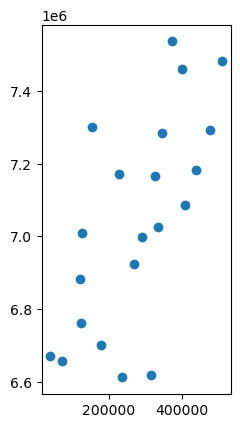

In [547]:
pos.plot()

In [557]:
for col in gdf.columns.tolist():
    gdf[col] = gdf[col]/1000000

In [574]:
planes_df = pd.DataFrame(index=["plane1","plane2","plane3"])

planes_df["cap"] = [20,50,100]
planes_df["cost"] = [30,60,110]
planes_df["max_dist"] = [400000, 700000, 2000000]
planes_df["land_cost"] = [110, 120, 140]

#add a zero plane:
zero_plane = pd.DataFrame(index=["noplane"])
zero_plane["cap"] = 0
zero_plane["cost"] = 0
zero_plane["max_dist"] = planes_df["max_dist"].max()
zero_plane["land_cost"] = 0
planes_df = pd.concat([zero_plane, planes_df], ignore_index=False)

planes_df["max_dist"] = planes_df["max_dist"]/1000000

In [575]:
#planes_df.drop("plane1", axis=0, inplace=True)
#planes_df.drop("plane2", axis=0, inplace=True)

In [576]:
planes = [n for n in planes_df.index.tolist()]
nodes = [i for i in df.index.tolist()]


    
max_dist = planes_df["max_dist"].max()
for node in nodes:
    min_dist = gdf[node].astype(float).nsmallest(2).tolist()[-1]
    if min_dist > max_dist:
        print(node, "is to far away from the system")
        

arcs = [(i,j) for i in nodes for j in nodes if i!=j] #check all arcs
D_ij = {} #length of arc i,j
N_ij = {} #planes available between i and j
poss_arcs = [] #only use possible arcs
for tup in arcs:
    dist_ij = gdf[tup[0]][tup[1]] #length of arc
    n_list = []
    for plane in planes: #check if there are any planes that 
        if planes_df["max_dist"][plane]>dist_ij:
            n_list.append(plane)
    if len(n_list) > 0:
        poss_arcs.append(tup)
        D_ij[tup] = dist_ij
        N_ij[tup] = n_list

all_arcs = arcs
arcs = poss_arcs #only use possible arcs

commodities = [h for h in nodes]
W_h_i = {} #demand of commodity h at node i

for node in nodes:
    com = node
    total_flow_in = df.loc[node].sum()
    W_h_i[(com, node)] = -total_flow_in
    
    for com in nodes:
        if com != node:
            flow_out = df[node][com]
            W_h_i[(com,node)] = flow_out


K_n = {}
C_n = {}
Cl_n = {}
for plane in planes:
    K_n[plane] = planes_df["cap"][plane]
    C_n[plane] = planes_df["cost"][plane]
    Cl_n[plane] = planes_df["land_cost"][plane]


arc_plane_n_ij = [(n,i,j) for (i,j) in arcs for n in N_ij[(i,j)]]

C_n_ij = {}
for (n,i,j) in arc_plane_n_ij:
    C_n_ij[(n,i,j)] = C_n[n]*D_ij[(i,j)]


CN_ij = {} #continous cost
KN_ij = {} #
Cl_N = {}
for arc in arcs:
    if len(N_ij[arc])>0:
        plane = N_ij[arc][-1]
        KN_ij[arc] = K_n[plane]/2
        P_N = C_n[plane]*D_ij[arc]/2#/K_n[plane]
        CN_ij[arc] = P_N
        Cl_N[arc] = planes_df["land_cost"][plane]/2
    else:
        KN_ij[arc] = 0
        CN_ij[arc] = 0
        Cl_N[arc] = 0



M = 0
for node in nodes:
    od = df[node].sum()
    M += od
    
M = np.ceil(M) + 1 #np.ceil(M/planes_df["cap"].max()) + 1  #max(max(KN_ij.values()), M) + 1

M_low = np.ceil(M/planes_df["cap"].max()) + 1  #max(max(KN_ij.values()), M) + 1


In [577]:
#model
try:
    m = gp.Model("airfleet")
    
    ###Variables:
    
    
    # Create variables
    f = m.addVars(commodities, arcs, name="F")
    g = m.addVars(arcs, vtype=GRB.BINARY, name="G") 
    a = m.addVars(arc_plane_n_ij, vtype=GRB.BINARY, name="A")
    ag = m.addVars(arcs, ub=M_low, vtype=GRB.INTEGER, name="AG")
    #u = m.addVars(arcs, name="U")
    #u_help = m.addVars(arcs, lb=-M, name="U_help")
    f_arc = m.addVars(arcs, name = "farc")
    #z_help = m.addVars(arcs, name="z_help") 
    #hub_help = m.addVars(nodes, name="hub_help")
    #hub = m.addVars(nodes, vtype=GRB.BINARY, name="hub")
    
    obj = a.prod(C_n_ij) + ag.prod(CN_ij) + ag.prod(Cl_N) + sum(sum(Cl_n[n]*a[n,i,j] for n in N_ij[(i,j)]) for (i,j) in arcs) 
    
    
    #Objective function (a)
    m.setObjective(obj, GRB.MINIMIZE)

    # Flow-conservation constraints
    m.addConstrs(
        (f.sum(h, '*', i) + W_h_i[h, i] == f.sum(h, i, '*')
         for h in commodities for i in nodes), "node")
    
    #F assign total flow on arc
    m.addConstrs((f_arc[i,j] == f.sum("*", i, j) for (i,j) in arcs), "H")

    
    #G see if we use more than one plane:
    m.addConstrs((g[i,j]*M >= f_arc[i,j] - KN_ij[(i,j)] for (i,j) in arcs), "8a")    # g=1 if flow> max capacity
    m.addConstrs(((1-g[i,j])*M >= KN_ij[(i,j)]- f_arc[i,j] for (i,j) in arcs), "8b") # g=0 if flow < max capacity
    
    #A pick a plane
    m.addConstrs((f_arc[i,j] <= sum(K_n[n]*a[n,i,j] for n in N_ij[(i,j)]) + KN_ij[i,j]*ag[i,j] for (i,j) in arcs), "9b") # ensure flow < capacity of the chosen plane
    m.addConstrs((sum(a[n,i,j] for n in N_ij[(i,j)]) + g[i,j] == 1 for (i,j) in arcs), "9a") # pick ONE plane OR pick ag
    
    
    m.addConstrs(M_low*g[i,j] >= ag[i,j] for (i,j) in arcs) #ensure that if you pick ag, then g = 1 
    m.addConstrs(M_low*(1-g[i,j]) >= -ag[i,j] + 0.0001 for (i,j) in arcs) #else 0
    
    #fly the plane back
    #this will become infeasible when symmetry is not ensured
    m.addConstrs(a[n,i,j] == a[n,j,i] for (n,i,j) in arc_plane_n_ij)
    m.addConstrs(ag[i,j] == ag[j,i] for (i,j) in arcs)
    
    
    
    #U calculate how much flow should be covered by "plane g", i.e. with continous flow (all or nothing)
    #m.addConstrs((u_help[i,j] == f_arc[i,j] - sum(K_n[n]*a[n,i,j] for n in N_ij[(i,j)]) for (i,j) in arcs), "10") 
    #for i,j in arcs:
    #    m.addConstr((u[i,j] == gp.max_(u_help[i,j], constant=0))) # u = 0 if a plane "a" was chosen
                                                                  # u = f_arc if "g" was chosen 

    #HUB 
    # keep track of which arcs are being used
    #m.addConstrs((z_help[i,j] == sum(a[n,i,j] for n in N_ij[(i,j)][1::]) for (i,j) in arcs), "10")  # if a plane besides "noplane" or was chosen
                                                                                                    # this arc is being used
    # compute the total amount of arcs going into and out of each node
    #m.addConstrs((hub_help[i] == z_help.sum(i,"*") + z_help.sum("*",i) for i in nodes), "12a")
    
    # assign hub-status
    #M_nodes = (len(nodes) + 1)*2 # Just a value that will always be higher than hub_help
    #m.addConstrs((hub[i]*M_nodes >= hub_help[i]-2  for i in nodes), "12b")             # if "nodes in and out" > 2, hub=1
    #m.addConstrs(((1-hub[i])*M_nodes >= 2-hub_help[i] + 0.001 for i in nodes), "12c")  # if "nodes in and out" <= 2, hub=0
    
    
    m.optimize()
    #for v in m.getVars():
    #    print('%s %g' % (v.VarName, v.X))
    
    print('Obj: %g' % m.ObjVal)

except gp.GurobiError as e:
    print('Error code ' + str(e.errno) + ': ' + str(e))

except AttributeError:
    print('Encountered an attribute error')

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) M-5Y31 CPU @ 0.90GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 5247 rows, 11526 columns and 37704 nonzeros
Model fingerprint: 0xaae6ec67
Variable types: 9240 continuous, 2286 integer (1866 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+04]
  Objective range  [7e+01, 2e+02]
  Bounds range     [1e+00, 2e+02]
  RHS range        [1e+00, 2e+04]
Presolve removed 2496 rows and 1539 columns
Presolve time: 0.97s
Presolved: 2751 rows, 9987 columns, 31665 nonzeros
Variable types: 9240 continuous, 747 integer (537 binary)
Found heuristic solution: objective 88774.313715

Root relaxation: objective 3.593274e+04, 6208 iterations, 1.99 seconds (0.80 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 35932.7355    0 

In [578]:
# retrieve hubs
# z_s = np.array(m.getAttr("X", z.values())).reshape((n_nodes,n_nodes))
# z_s = z_s.round(1)

# find value True for each row (representing the corresponding hub)
# gdf["hub"] = np.argmax(z_s, axis=1) == range(n_nodes)

# retrieve flow solution
f_arc_s = m.getAttr("X", f_arc)

# retrieve which legs are flown by which plane
a_s = m.getAttr("X", a)
a_sd = {(o, d): plane for (plane, o, d), v in a_s.items() if v != 0}
g_s = m.getAttr("X", g)
g_sd = {k: "over" for k, v in g_s.items() if v != 0}

# note that the legs are not always doable by the plane, so we need to check that before counting the number of legs by planes
planes_leg = {**a_sd, **g_sd}

In [579]:
i = 0

flow_dic = {}
hub_dic = {}
for node in df.index.tolist():
    flow_dic[node] = 0
    hub_dic[node] = 0

for key, val in m.getAttr("X", f).items():
    com = key[0]
    nod0 = key[1]
    nod1 = key[2]
    if com != nod1:
        flow_dic[nod1] += val
        if val > 1:
            try:
                plane = a_sd[nod0,nod1]
            except:
                plane = planes[-1]
#            if com==nod0:
#                print(key, val)
            if plane == planes[-1]:
                hub_dic[nod1] +=1
pos["fin_flow"] = flow_dic.values()

pos["hub"] = hub_dic.values()
pos["hub"] = pos["hub"] >= 1

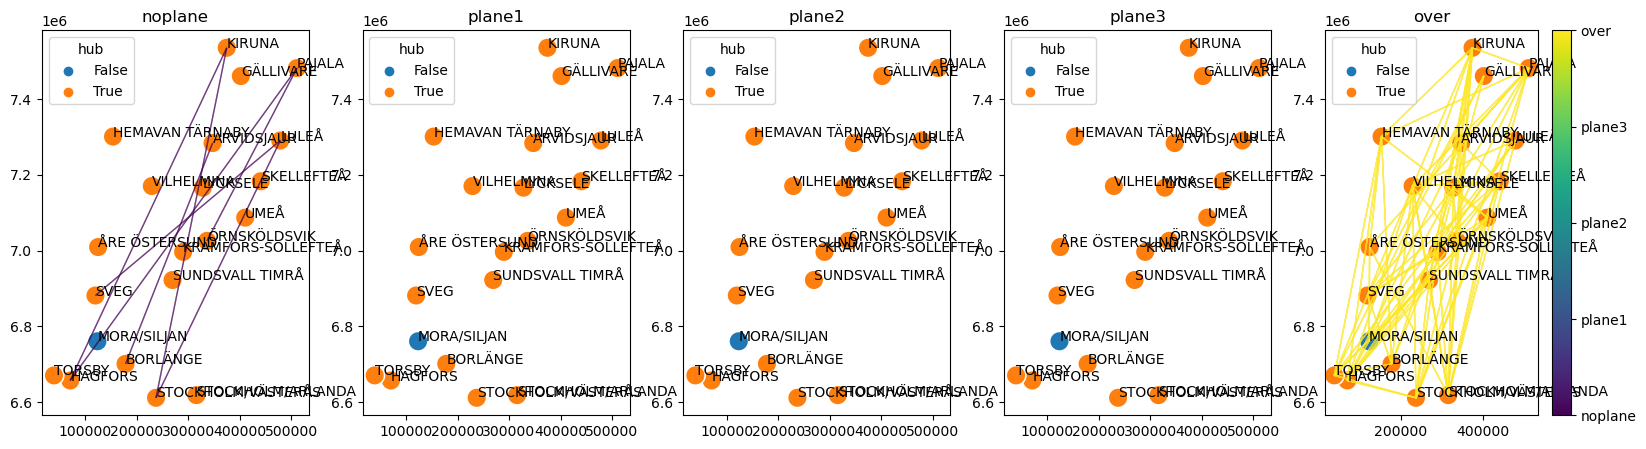

In [580]:


fig, ax = plt.subplots(1, len(planes)+1, figsize=(20,5))

for j, plane in enumerate(planes+["over"]):
    # Plot nodes with edges with the hubs
    sns.scatterplot(data=pos, x=pos["geometry"].x, y=pos["geometry"].y, s=200, hue='hub', legend=True, ax=ax[j])
    for i, point in pos.iterrows():
        ax[j].text(point["geometry"].x +.02, point["geometry"].y + 0.02, str(i))
        

    # Now connect the legs with lines
    cmap = plt.get_cmap('viridis')
    colors = cmap(np.linspace(0, 1, len(planes)+1))
    p_to_c = {p:c for p,c in zip(planes + ['over'], colors)}

    for p,q in arcs:
        if planes_leg[p,q] == plane and df[p][q] > 20:
            ax[j].arrow(pos.geometry[p].x, pos.geometry[p].y, pos.geometry[q].x - pos.geometry[p].x, pos.geometry[q].y - pos.geometry[p].y, width=f_arc_s[p,q]*0.005, length_includes_head=True, color=p_to_c[planes_leg[p,q]], alpha=0.5)
    ax[j].set_title(plane)

# show colorbar for planes
cbar = fig.colorbar(mappable=ScalarMappable(cmap=cmap), ticks=np.linspace(0, 1, len(planes)+1))
cbar.ax.set_yticklabels(planes + ['over']);

In [572]:
df["LYCKSELE"]["PAJALA"]

22.0

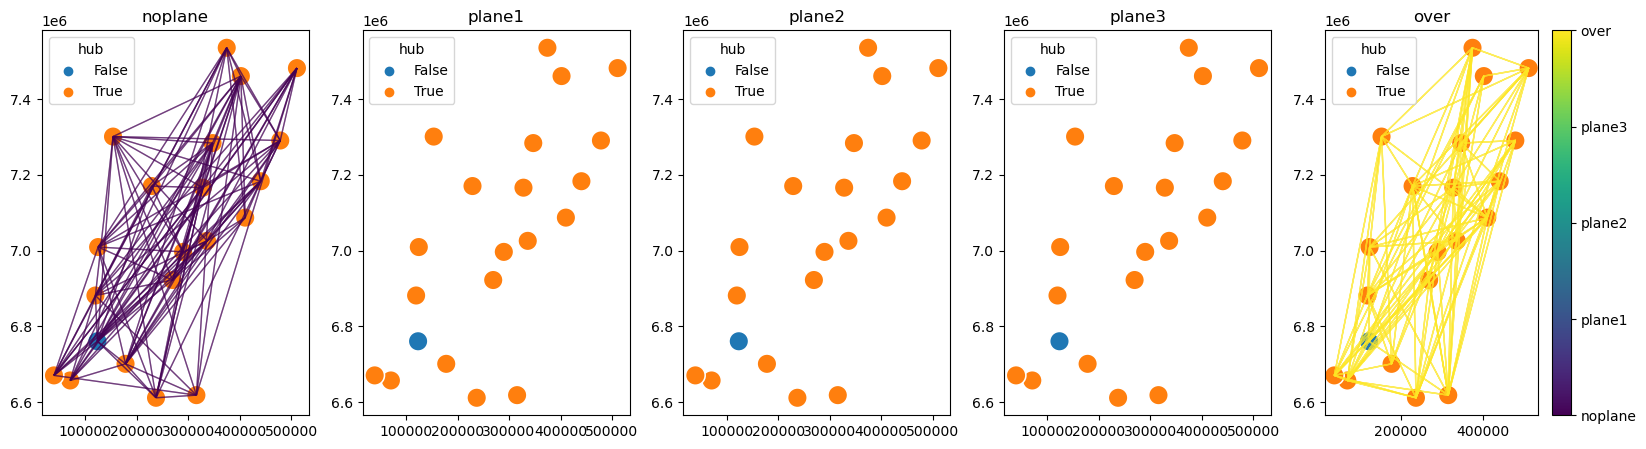

In [581]:


fig, ax = plt.subplots(1, len(planes)+1, figsize=(20,5))

for j, plane in enumerate(planes+["over"]):
    # Plot nodes with edges with the hubs
    sns.scatterplot(data=pos, x=pos["geometry"].x, y=pos["geometry"].y, s=200, hue='hub', legend=True, ax=ax[j])
#    for i, point in pos.iterrows():
#        ax[j].text(point["geometry"].x +.02, point["geometry"].y + 0.02, str(i))
        

    # Now connect the legs with lines
    cmap = plt.get_cmap('viridis')
    colors = cmap(np.linspace(0, 1, len(planes)+1))
    p_to_c = {p:c for p,c in zip(planes + ['over'], colors)}

    for p,q in arcs:
        if planes_leg[p,q] == plane:# and f_arc_s[p,q] > 0:
            ax[j].arrow(pos.geometry[p].x, pos.geometry[p].y, pos.geometry[q].x - pos.geometry[p].x, pos.geometry[q].y - pos.geometry[p].y, width=f_arc_s[p,q]*0.005, length_includes_head=True, color=p_to_c[planes_leg[p,q]], alpha=0.5)
    ax[j].set_title(plane)

# show colorbar for planes
cbar = fig.colorbar(mappable=ScalarMappable(cmap=cmap), ticks=np.linspace(0, 1, len(planes)+1))
cbar.ax.set_yticklabels(planes + ['over']);

In [213]:
# count the number of legs by plane
legs_by_plane = {plane:0 for plane in planes+["over"]}
for p,q in arcs:
    legs_by_plane[planes_leg[p,q]] += 1 * (f_arc_s[p,q] != 0)
legs_by_plane

{'noplane': 0, 'plane1': 14, 'plane2': 16, 'plane3': 12, 'over': 0}

In [123]:
f_arc_s

{('ÄNGELHOLM', 'ÅRE ÖSTERSUND'): 0.0,
 ('ÄNGELHOLM', 'ARVIDSJAUR'): 0.0,
 ('ÄNGELHOLM', 'BORLÄNGE'): 0.0,
 ('ÄNGELHOLM', 'GÄLLIVARE'): 0.0,
 ('ÄNGELHOLM', 'GÖTEBORG/LANDVETTER'): 100.00000000027777,
 ('ÄNGELHOLM', 'GÖTEBORG/SÄVE'): 100.00000002089311,
 ('ÄNGELHOLM', 'HAGFORS'): 0.0,
 ('ÄNGELHOLM', 'HALMSTAD'): 100.00000000000001,
 ('ÄNGELHOLM', 'HEMAVAN TÄRNABY'): 0.0,
 ('ÄNGELHOLM', 'JÖNKÖPING'): 100.0,
 ('ÄNGELHOLM', 'KALMAR'): 2.775977736180588e-10,
 ('ÄNGELHOLM', 'KARLSTAD'): 0.0,
 ('ÄNGELHOLM', 'KIRUNA'): 0.0,
 ('ÄNGELHOLM', 'KRAMFORS-SOLLEFTEÅ'): 0.0,
 ('ÄNGELHOLM', 'KRISTIANSTAD'): 20.0,
 ('ÄNGELHOLM', 'LINKÖPING'): 100.0,
 ('ÄNGELHOLM', 'LULEÅ'): 0.0,
 ('ÄNGELHOLM', 'LYCKSELE'): 0.0,
 ('ÄNGELHOLM', 'MALMÖ'): 100.0,
 ('ÄNGELHOLM', 'MORA/SILJAN'): 0.0,
 ('ÄNGELHOLM', 'NORRKÖPING/KUNGSÄNGEN'): 100.0,
 ('ÄNGELHOLM', 'ÖREBRO'): 0.0,
 ('ÄNGELHOLM', 'ÖRNSKÖLDSVIK'): 0.0,
 ('ÄNGELHOLM', 'OSKARSHAMN'): 0.0,
 ('ÄNGELHOLM', 'PAJALA'): 0.0,
 ('ÄNGELHOLM', 'RONNEBY'): 0.0,
 ('ÄNGELHOLM', 'S

In [188]:
gdf

,ÄNGELHOLM,ÅRE ÖSTERSUND,ARVIDSJAUR,BORLÄNGE,GÄLLIVARE,GÖTEBORG/LANDVETTER,GÖTEBORG/SÄVE,HAGFORS,HALMSTAD,HEMAVAN TÄRNABY
ÄNGELHOLM,0.000000,0.774227,1.092273,0.485994,1.277458,0.156665,0.175232,0.417948,0.042666,1.067077
ÅRE ÖSTERSUND,0.774227,0.000000,0.353086,0.312862,0.529559,0.627569,0.620733,0.356326,0.731730,0.293035
ARVIDSJAUR,1.092273,0.353086,0.000000,0.606719,0.185189,0.956791,0.954253,0.684837,1.051024,0.194003
BORLÄNGE,0.485994,0.312862,0.606719,0.000000,0.791884,0.358650,0.361572,0.116019,0.445213,0.600396
GÄLLIVARE,1.277458,0.529559,0.185189,0.791884,0.000000,1.141439,1.138464,0.869074,1.236192,0.295086
GÖTEBORG/LANDVETTER,0.156665,0.627569,0.956791,0.358650,1.141439,0.000000,0.027664,0.273093,0.115606,0.919148
GÖTEBORG/SÄVE,0.175232,0.620733,0.954253,0.361572,1.138464,0.027664,0.000000,0.269421,0.136119,0.911102
HAGFORS,0.417948,0.356326,0.684837,0.116019,0.869074,0.273093,0.269421,0.000000,0.375421,0.649129
HALMSTAD,0.042666,0.731730,1.051024,0.445213,1.236192,0.115606,0.136119,0.375421,0.000000,1.024537
HEMAVAN TÄRNABY,1.067077,0.293035,0.194003,0.600396,0.295086,0.919148,0.911102,0.649129,1.024537,0.000000


In [189]:
planes_df

,cap,cost,max_dist,land_cost
noplane,0,0,2.0,0
plane1,20,20,0.1,1
plane2,50,50,0.4,1
plane3,100,100,2.0,1
